## 1. Data Loading and Conversion

In [1]:
import numpy as np
x = np.load('./AtlasGNNinput/BASC-197_correlation_correlation.npy')  # Shape
y = np.load('./AtlasGNNinput/Y.npy')  # Assuming shape: (871,)

print(x.shape)
print(y.shape)

(871, 197, 197)
(871,)


## 2. Graph Arrangement

In [2]:
num_graphs, num_nodes, _ = x.shape
print(x.shape)
num_features = num_nodes * (num_nodes - 1) // 2   

print("num_graphs:", num_graphs)   
print("num_nodes:", num_nodes)    
print("num_features:", num_features)  

# List mapping each “feature index” [0..E]  to an (i,j) pair in the upper triangle
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

(871, 197, 197)
num_graphs: 871
num_nodes: 197
num_features: 19306


## 3. Parameters for trials and selection

In [3]:
num_selected = int(0.20 * num_features)  # 20% of
num_trials = 500  # number of repetitions.( I reduced for now due to how long it will take)
num_epochs = 30  # number of training epochs per trial. ( reduced for same reason)

# Create arrays to store each trial's selected indices and accuracy.
# The indices array is shaped as (num_selected, num_trials), where each column represents one trial.
indices_matrix = np.zeros((num_selected, num_trials), dtype=int)
accuracy_vector = np.zeros(num_trials)

## 4. Generate Graph Function

In [4]:
import torch
from torch_geometric.data import Data

def generate_multiple_graphs(X, y):
    """
    Generate multiple PyTorch Geometric graph objects from full symmetric adjacency matrices.
    
    Parameters:
        X (numpy.ndarray): 3D array of shape (num_graphs, N_nodes, N_nodes) where each entry is an adjacency matrix.
        y (numpy.ndarray): 1D array of graph labels.
    
    Returns:
        List[Data]: A list of PyTorch Geometric Data objects.
    """
    graphs = []
    num_graphs = X.shape[0]
    N_nodes = X.shape[1] # Assuming square adjacency matrices

    for graph_idx in range(num_graphs):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]

        # Initialize node features,edge index and weight.
        node_features = [[1,] for _ in range(N_nodes)]
        edge_index = []
        edge_weight = []

        # Iterate over upper triangle to avoid self-loops and duplicate edges
        for i in range(N_nodes):
            for j in range(i + 1, N_nodes): # Avoiding self-loops and duplicate edges
                weight = adjacency_matrix[i, j]
                if weight != 0: # Only include edges with non-zero weight
                    # Add both (i, j) and (j, i) for undirected graph
                    edge_index.append([i, j])
                    edge_weight.append(weight) # I removed the additional edge_index since the graph is undirected. 
                                       
                    # Update node features by accumulating connected edge weights
                    node_features[i][0] += weight
                    node_features[j][0] += weight

        # Convert lists to PyTorch tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
                     
    return graphs

## 5. GNN Model

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        # 1st GATv2 layer: input_dim → hidden_dim, using 'heads' attention heads
        # edge_dim=1 since each edge has one feature (FC weight)
        self.gat1 = GATv2Conv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 2nd GATv2 layer: (hidden_dim * heads) → hidden_dim
        self.gat2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 3rd GATv2 layer: (hidden_dim * heads) → output_dim, single head, no concat
        self.gat3 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=output_dim,
            heads=1,
            concat=False,
            dropout=0.3,
            edge_dim=1
        )
        # Final linear layer for binary classification
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Reshape edge_weight from (E,) → (E, 1)
        ew = edge_weight.view(-1, 1)

        # 1) Apply first GATv2 + ReLU
        x = F.relu(self.gat1(x, edge_index, ew))
        # 2) Apply second GATv2 + ReLU
        x = F.relu(self.gat2(x, edge_index, ew))
        # 3) Apply third GATv2 (no activation)
        x = self.gat3(x, edge_index, ew)
        # 4) Global mean pool over nodes → one graph vector
        x = global_mean_pool(x, batch)
        # 5) Linear layer + sigmoid for binary output
        x = self.fc(x)
        return torch.sigmoid(x)

## 6. Training and Evaluation Functions 

In [6]:
def train(model, loader, optimizer, criterion):
    # Train the model for one epoch over the given data loader
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        # Forward pass
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        # Compute loss (reshape output to match labels)
        loss = criterion(out.squeeze(1), data.y.float())
        # Backward pass and weight update
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Return the average loss per batch
    return total_loss / len(loader)


def evaluate(model, loader):
    # Compute overall accuracy of the model on the provided data loader
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Convert probabilities to binary predictions (threshold = 0.5)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    # Return the fraction of correctly classified graphs
    return correct / total


def eval_loss(model, loader, criterion):
    # Compute the average loss of the model over all graphs in the loader
    model.eval()
    total_loss = 0.0
    total_graphs = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Compute loss for this batch, weighted by number of graphs
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs

    # Return the average loss per graph
    return total_loss / total_graphs

## 7. Main Loop: Trails of random column removal, train/test split and graph generation/classiication

In [7]:
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

for trial in range(num_trials):
    print(f"Trial {trial+1}/{num_trials}")

    # 1) Randomly select 20% of the ? upper‐triangle “features” (each maps to one (i,j) pair)
    selected_feat_idxs = np.random.choice(num_features, size=num_selected, replace=False)
    indices_matrix[:, trial] = selected_feat_idxs  # Save selected indices for this trial

    # 2) Create a modified copy of the full (871, 116, 116) FC matrices
    X_mod = x.copy()  # x.shape 

    #    Zero out each chosen edge (i,j) and its mirror (j,i) across all subjects
    for feat_idx in selected_feat_idxs:
        i, j = edge_pairs[feat_idx]
        X_mod[:, i, j] = 0.0
        X_mod[:, j, i] = 0.0

    # 3) Generate PyG graphs from the masked FC matrices
    graphs = generate_multiple_graphs(X_mod, y)

    # 4) Split graphs into train/val/test (80/10/10)
    dataset_size = len(graphs)
    train_size   = int(0.8 * dataset_size)
    val_size     = int(0.1 * dataset_size)
    test_size    = dataset_size - train_size - val_size
    train_data, val_data, test_data = random_split(graphs, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_data,   batch_size=32)
    test_loader  = DataLoader(test_data,  batch_size=32)

    # 5) Initialize model, loss, optimizer, and scheduler 
    model     = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # 6) Training loop 
    best_val_loss    = float('inf')
    best_model_state = None
    wait             = 0
    patience         = 10

    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss   = eval_loss(model, val_loader, criterion)
        val_acc    = evaluate(model, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = model.state_dict()
            wait             = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"--> Early stopping at epoch {epoch} (no val_loss improvement in {patience} epochs)")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 7) Test‐set evaluation
    test_acc = evaluate(model, test_loader)
    accuracy_vector[trial] = test_acc
    print(f"Trial {trial+1} Test Acc: {test_acc:.4f}")

Trial 1/500


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 — Train Loss: 0.7210, Val Loss: 0.6671, Val Acc: 0.6207
Epoch 02 — Train Loss: 0.7046, Val Loss: 0.6637, Val Acc: 0.6092
Epoch 03 — Train Loss: 0.7162, Val Loss: 0.6663, Val Acc: 0.6207
Epoch 04 — Train Loss: 0.7042, Val Loss: 0.6649, Val Acc: 0.6207
Epoch 05 — Train Loss: 0.7060, Val Loss: 0.6712, Val Acc: 0.5977
Epoch 06 — Train Loss: 0.7017, Val Loss: 0.6765, Val Acc: 0.5632
Epoch 07 — Train Loss: 0.7070, Val Loss: 0.6727, Val Acc: 0.5862
Epoch 08 — Train Loss: 0.6958, Val Loss: 0.6655, Val Acc: 0.6207
Epoch 09 — Train Loss: 0.6954, Val Loss: 0.6666, Val Acc: 0.6207
Epoch 10 — Train Loss: 0.6991, Val Loss: 0.6679, Val Acc: 0.6207
Epoch 11 — Train Loss: 0.6972, Val Loss: 0.6677, Val Acc: 0.6207
Epoch 12 — Train Loss: 0.6959, Val Loss: 0.6707, Val Acc: 0.6207
--> Early stopping at epoch 12 (no val_loss improvement in 10 epochs)
Trial 1 Test Acc: 0.4545
Trial 2/500
Epoch 01 — Train Loss: 1.1258, Val Loss: 1.0602, Val Acc: 0.4483
Epoch 02 — Train Loss: 0.8998, Val Loss: 0.8572,

# 8. Saving recall indices/accuracy as npy.files

In [8]:
np.save('selected_indices_basc197(500t-corr).npy', indices_matrix)# Showcase each column(trial) of indices that were zeroed out. 
np.save('accuracy_vector_basc197(500t-corr).npy', accuracy_vector) # Showcase test accuracy for each trial. 500 trials=500 entries. 

print("Processing complete. The selected indices and accuracy vector have been saved.")

Processing complete. The selected indices and accuracy vector have been saved.


# 9. Post-hockey Analysis ( Determing Influence)

In [9]:
# Transpose indices_matrix so each row corresponds to one trial
indices_matrix_transposed = indices_matrix.T  # Shape: (num_trials, num_selected)

# Compute median accuracy across all trials
median_acc = np.median(accuracy_vector)
print("Median accuracy across trials:", median_acc)

# Split trials into “good” (>= median) and “bad” (< median)
good_trials = indices_matrix_transposed[accuracy_vector >= median_acc]
bad_trials  = indices_matrix_transposed[accuracy_vector <  median_acc]

# Flatten the selected indices for each category
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([])
bad_indices  = bad_trials.flatten()  if bad_trials.size  > 0 else np.array([])

# Count how often each of the num_features indices was chosen
freq_good = np.bincount(good_indices, minlength=num_features)
freq_bad  = np.bincount(bad_indices,  minlength=num_features)

# Extract the top 50 most frequent indices in each category
top_k = 50
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

print("\nTop 50 indices for good trials and their frequencies:")
for idx in top_good_idx:
    print(f"Index {idx}: {freq_good[idx]} occurrences")

print("\nTop 50 indices for bad trials and their frequencies:")
for idx in top_bad_idx:
    print(f"Index {idx}: {freq_bad[idx]} occurrences")


Median accuracy across trials: 0.5113636363636364

Top 50 indices for good trials and their frequencies:
Index 8372: 79 occurrences
Index 2295: 79 occurrences
Index 6100: 78 occurrences
Index 11799: 78 occurrences
Index 5279: 78 occurrences
Index 4239: 77 occurrences
Index 10657: 77 occurrences
Index 16284: 77 occurrences
Index 12049: 77 occurrences
Index 791: 77 occurrences
Index 4000: 76 occurrences
Index 7805: 76 occurrences
Index 15650: 75 occurrences
Index 15920: 75 occurrences
Index 15210: 74 occurrences
Index 12736: 74 occurrences
Index 3399: 74 occurrences
Index 11880: 74 occurrences
Index 3881: 74 occurrences
Index 5004: 73 occurrences
Index 10218: 73 occurrences
Index 13656: 73 occurrences
Index 92: 73 occurrences
Index 14442: 73 occurrences
Index 681: 73 occurrences
Index 4856: 73 occurrences
Index 8699: 73 occurrences
Index 8235: 73 occurrences
Index 6996: 73 occurrences
Index 6888: 73 occurrences
Index 5569: 73 occurrences
Index 9328: 73 occurrences
Index 16998: 72 occurre

## 10. Preview Saved Files

In [10]:
accuracy_vector = np.load('selected_indices_basc197(500t-corr).npy') # when you have required file from custom path
print(accuracy_vector)

[[ 2939  8662 17435 ... 16720 18071  1924]
 [15603 11320  5087 ...  5928 17847  1832]
 [ 9143  7136  5671 ... 11781  2547 11261]
 ...
 [18286  2643 12920 ...   782 16786 17694]
 [14559 19165 16173 ... 16125  8478  2407]
 [18262  4430  2839 ...  6481 18248  5846]]


In [11]:
selected_indices = np.load('selected_indices_basc197(500t-corr).npy') # when you have required file from custom path
import pandas as pd
df = pd.DataFrame(selected_indices)
print(df)

        0      1      2      3      4      5      6      7      8      9    \
0      2939   8662  17435  17495   7877  13625  13653  15359  11792  13177   
1     15603  11320   5087   8507  12366  18652  10314   1502   9075   2065   
2      9143   7136   5671   7297  12959  13301  18958   8414  13497   8299   
3      4787  13685   6875  13945   1407  13622   9709  10846   6926  18716   
4      4430   9348   9209   9429  16059   1187  18552  11125  18551   5656   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3856   4799  13927  19081  16576  10873  14175   4820  18185   7472   5318   
3857   2113   8064   7598   3759   3274   2790   2682  15653  11545   4162   
3858  18286   2643  12920   8902  17795   8088   5494   9832   4990  18017   
3859  14559  19165  16173  18441    648   8863   7420   4505  15717   7446   
3860  18262   4430   2839    352   8603  11950  16418  12049   3548  18121   

      ...    490    491    492    493    494    495    496    4

In [13]:
!pip install nilearn
!pip install --upgrade nilearn
from nilearn.datasets import fetch_atlas_basc_multiscale_2015

## 11. Nilearn Visulization

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

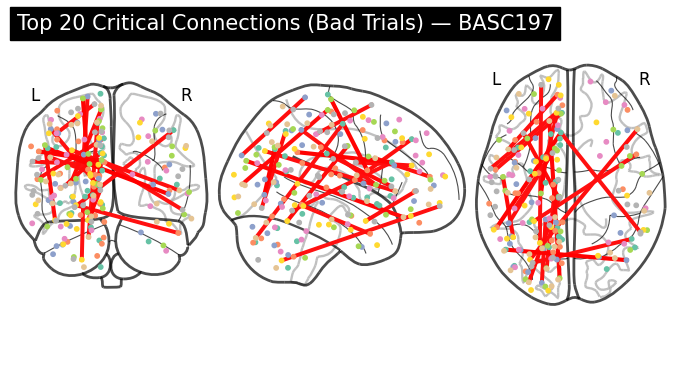

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC197
num_nodes    = 197
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20  # how many top edges to show

# Load the selected edge indices and accuracy per trial
selected_indices = np.load('selected_indices_basc197(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc197(500t-corr).npy')   # (num_trials,)

# Find all trials where accuracy is below the median (bad trials) as well as the bad indices
indices_matrix = selected_indices.T  # shape: (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)
bad_trials     = indices_matrix[accuracy_vector < median_acc]
bad_indices    = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)

# Count how often each edge appears in bad trials
freq_bad = np.bincount(bad_indices, minlength=num_features)

# Pick the top_k edges that appear most often in bad trials
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

# Helper to convert a flat edge index k to (i,j) in a n*n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            j = i + 1 + (k - total)
            return i, j
        total += count
    raise ValueError("Index out of range.")

# Build a symmetric “frequency” matrix for those critical edges
matrix_critical = np.zeros((num_nodes, num_nodes))
for idx in top_bad_idx:
    i, j = index_to_coords(int(idx))
    matrix_critical[i, j] = freq_bad[idx]
    matrix_critical[j, i] = freq_bad[idx]

# Fetch AAL centroids for plotting
basc = fetch_atlas_basc_multiscale_2015()           
coords = plotting.find_parcellation_cut_coords(basc.scale197)  

# Plot only those critical connections on a glass brain
threshold = freq_bad[top_bad_idx[-1]]  # lowest frequency among the chosen edges
display = plotting.plot_connectome(
    matrix_critical,
    coords,
    edge_threshold=threshold,
    node_size=10,
    title=f"Top {top_k} Critical Connections (Bad Trials) — BASC197"
)

plt.show()

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

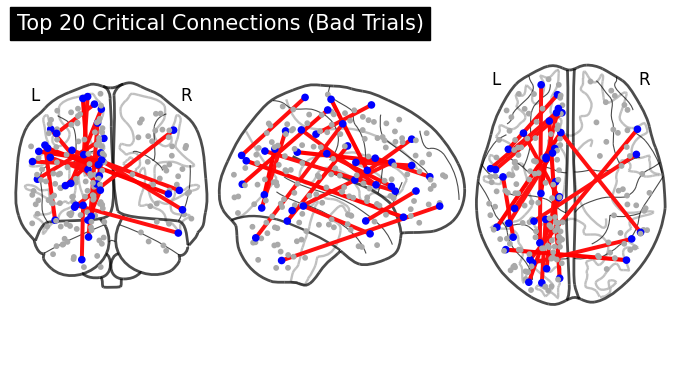

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

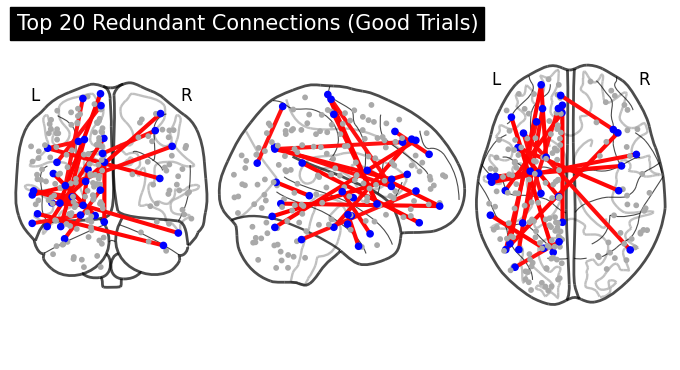

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC197
num_nodes    = 197
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20      # edges per category

# Load trial data
selected_indices = np.load('selected_indices_basc197(500t-corr).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc197(500t-corr).npy')   # shape: (num_trials,)

# Prepare split by median accuracy
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

# Bad trials / critical edges
bad_trials     = accuracy_vector < median_acc
bad_indices  = indices_matrix[bad_trials].flatten() if bad_trials.any() else np.array([], dtype=int)
freq_bad     = np.bincount(bad_indices, minlength=num_features)
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

# Good trials / redundant edges
good_trials     = accuracy_vector >= median_acc
good_indices  = indices_matrix[good_trials].flatten() if good_trials.any() else np.array([], dtype=int)
freq_good     = np.bincount(good_indices, minlength=num_features)
top_good_idx  = np.argsort(freq_good)[-top_k:][::-1]

# Index→(i,j) helper for upper‐triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    tot = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < tot + cnt:
            return i, i + 1 + (k - tot)
        tot += cnt
    raise ValueError(f"Index {k} out of range")

# Plotting helper
def plot_edges(edge_idx_list, freq_arr, title):
    # build full symmetric weight matrix
    M = np.zeros((num_nodes, num_nodes))
    connected = np.zeros(num_nodes, bool)
    for k in edge_idx_list:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_arr[k]
        M[j, i] = freq_arr[k]
        connected[[i, j]] = True

    # node styling
    node_sizes  = [20 if c else 10 for c in connected]
    node_colors = ['blue' if c else 'darkgray' for c in connected]

    # fetch BASC197 centroids
    basc = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale197)

    # edge threshold = smallest of the top‐K freqs
    thresh = float(freq_arr[edge_idx_list[-1]])
    plotting.plot_connectome(
        M, coords,
        edge_threshold=thresh,
        node_size=node_sizes,
        node_color=node_colors,
        title=title
    )
    plt.show()

# Visualize both panels
plot_edges(top_bad_idx,  freq_bad,  f"Top {top_k} Critical Connections (Bad Trials)")
plot_edges(top_good_idx, freq_good, f"Top {top_k} Redundant Connections (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

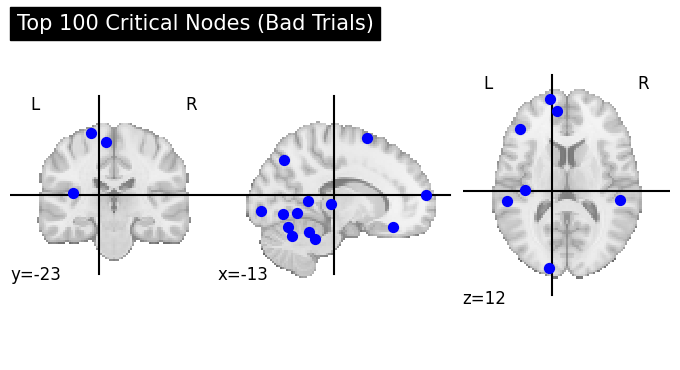

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

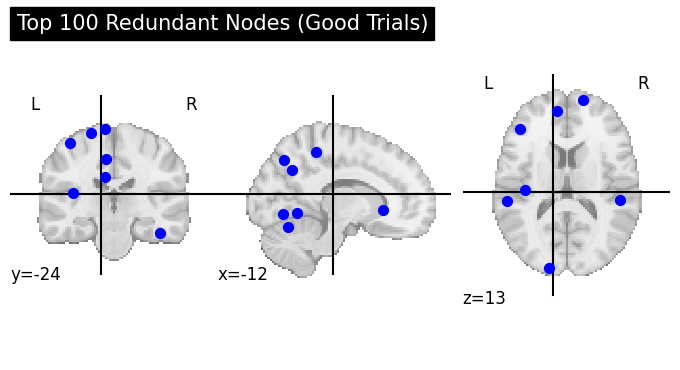

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Parameters for BASC197
num_nodes    = 197
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 100

# Load trial data
selected_indices = np.load('selected_indices_basc197(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc197(500t-corr).npy')   # (num_trials,)

# Prepare median split
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

bad_trials  = indices_matrix[accuracy_vector < median_acc]
bad_indices = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)
freq_bad    = np.bincount(bad_indices, minlength=num_features)
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

good_trials  = indices_matrix[accuracy_vector >= median_acc]
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([], dtype=int)
freq_good    = np.bincount(good_indices, minlength=num_features)
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]

#  Map 1D edge-index → (i, j) in the n×n matrix 
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            return i, i + 1 + (k - total)
        total += count
    raise ValueError(f"Index {k} out of range for n={n}.")

# Plot nodes on ortho slices centered on their centroid
def plot_nodes_ortho(edge_idx_list, title):
    # 1. Flag which nodes are involved
    connected = np.zeros(num_nodes, dtype=bool)
    for idx in edge_idx_list:
        i, j = index_to_coords(int(idx))
        connected[i] = True
        connected[j] = True

    # 2. Fetch BASC197 centroids
    basc   = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale197)

    # 3. Extract only the active-node coords
    coords_active = np.array([coords[i] for i, flag in enumerate(connected) if flag])
    if coords_active.size == 0:
        print(f"No nodes to plot for: {title}")
        return

    # 4. Compute mean center
    center = tuple(coords_active.mean(axis=0))

    # 5. Plot the anatomical slices
    display = plotting.plot_anat(
        title=title,
        display_mode='ortho',
        cut_coords=center
    )

    # 6. Overlay markers at each active centroid
    display.add_markers(
        coords_active.tolist(),
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Visualize critical vs. redundant nodes
plot_nodes_ortho(top_bad_idx,  f"Top {top_k} Critical Nodes (Bad Trials)")
plot_nodes_ortho(top_good_idx, f"Top {top_k} Redundant Nodes (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

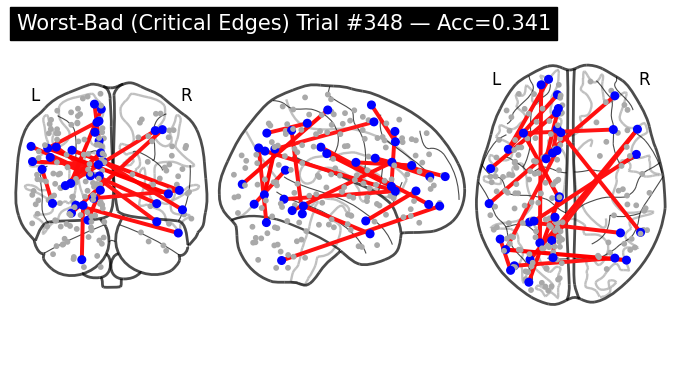

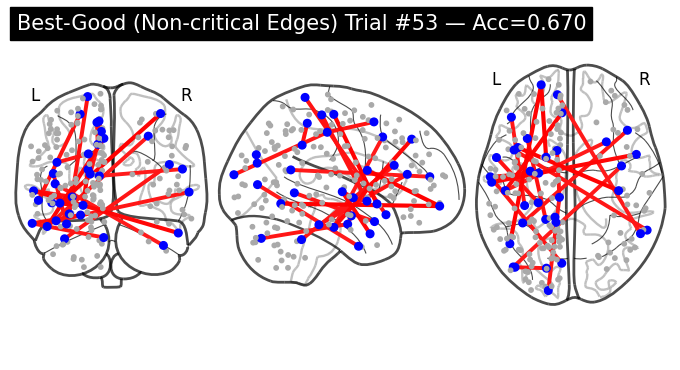

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Load your trial data 
selected_indices = np.load('selected_indices_basc197(500t-corr).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc197(500t-corr).npy')   # shape: (num_trials,)

# Parameters for BASC197
num_nodes    = 197
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

#  Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

# Identify the single worst (lowest‐acc) bad trial and best (highest‐acc) good trial
bad_trials = all_trials[bad_trials]
best_bad   = bad_trials[np.argmin(accuracy_vector[bad_trials])] if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] if good_trials.size else None

# Precompute global edge frequencies over bad vs. good sets
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

# Helper: map 1D edge‐index → (i,j) in the upper triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Fetch BASC197 centroids once
basc    = fetch_atlas_basc_multiscale_2015()
coords  = plotting.find_parcellation_cut_coords(basc.scale197)

def plot_top20(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return

    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]   # which edges were zeroed in that trial

    # rank those edges by their overall freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # build n×n adjacency with only those edges
    M = np.zeros((num_nodes, num_nodes))
    involved = np.zeros(num_nodes, bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_array[int(k)]
        M[j, i] = freq_array[int(k)]
        involved[i] = True
        involved[j] = True

    # style nodes
    sizes  = [30 if involved[n] else 10 for n in range(num_nodes)]
    colors = ['blue' if involved[n] else 'darkgray' for n in range(num_nodes)]

    plotting.plot_connectome(
        M,
        coords,
        edge_threshold=min(freq_array[top20]),
        node_size=sizes,
        node_color=colors,
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}"
    )
    plt.show()

# Plot the two panels
plot_top20(best_bad,  freq_bad,  "Worst-Bad (Critical Edges)")
plot_top20(best_good, freq_good, "Best-Good (Non-critical Edges)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

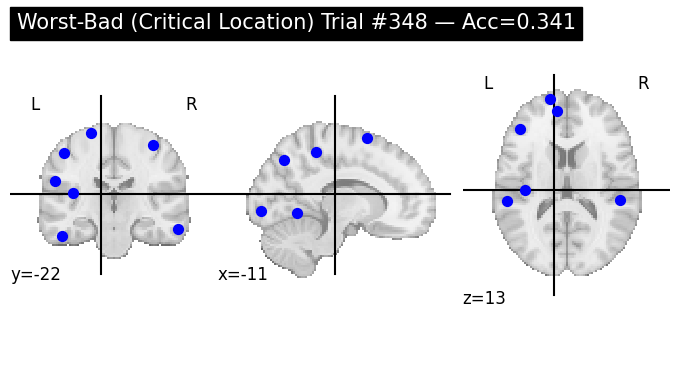

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/basc_multiscale_2015

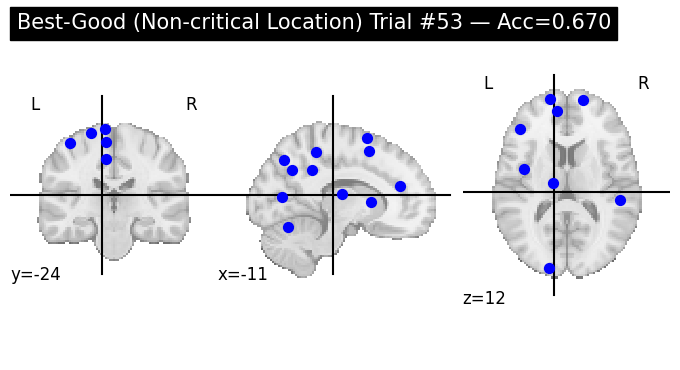

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
from nilearn import plotting

# Load your trial data
selected_indices = np.load('selected_indices_basc197(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_basc197(500t-corr).npy')   # (num_trials,)

# Parameters for BASC197
num_nodes    = 197
num_features = num_nodes * (num_nodes - 1) // 2   
top_k        = 100

# Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

bad_trials  = all_trials[bad_trials]
best_bad    = bad_trials[np.argmin(accuracy_vector[bad_trials])] \
                if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] \
                if good_trials.size else None

# Global edge‐frequency maps
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

#  Helper: map 1D edge‐index → (i,j) in n×n upper triangle
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Ortho‐slice plotting for the top-5 edges of one trial
def plot_top20_ortho(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return
    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]  # edges zeroed in this trial

    # rank this trial’s edges by their global freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # mark which nodes get involved
    involved = np.zeros(num_nodes, dtype=bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        involved[i] = True
        involved[j] = True

    # fetch BASC197 centroids
    basc   = fetch_atlas_basc_multiscale_2015()
    coords = plotting.find_parcellation_cut_coords(basc.scale197)

    # select only the active-node coords
    coords_active = [coords[i] for i, flag in enumerate(involved) if flag]
    if not coords_active:
        print(f"No nodes to plot for {label} Trial #{trial_idx}")
        return

    # center the ortho view
    center = tuple(np.mean(coords_active, axis=0))

    # show the anatomy + markers
    display = plotting.plot_anat(
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}",
        display_mode='ortho',
        cut_coords=center
    )
    display.add_markers(
        coords_active,
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Render both panels
plot_top20_ortho(best_bad,  freq_bad,  "Worst-Bad (Critical Location)")
plot_top20_ortho(best_good, freq_good, "Best-Good (Non-critical Location)")